In [4]:
# 필요라이브러리 가져오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
from folium.plugins import MousePosition
from pyproj import Proj, Transformer 
import json

In [28]:
# 한글 깨짐 방지
import matplotlib
from matplotlib import font_manager, rc
import platform
if platform.system()=="Windows":
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings("ignore")

# 1. Data의 이해

## 데이터 정의

* YM	: 기준년월m
* SIDO	: 지역대분류명
* SIGUNGU	: 지역중분류명
* FranClass	: 소상공인구분
* Type	: 업종명
* Time	: 시간대
* TotalSpent	: 총사용금액
* DisSpent	: 재난지원금 사용금액
* NumOfSpent	: 총 이용건수
* NumOfDisSpent	: 총 재난지원금 이용건수
* POINT_X, POINT_Y	: X,Y 좌표

In [29]:
temp1 = pd.read_csv(f'data/KRI-DAC_Jeju_data5.txt', encoding='utf-8')
temp2 = pd.read_csv(f'data/KRI-DAC_Jeju_data6.txt', encoding='utf-8')
temp3 = pd.read_csv(f'data/KRI-DAC_Jeju_data7.txt', encoding='utf-8')
temp4 = pd.read_csv(f'data/KRI-DAC_Jeju_data8.txt', encoding='utf-8')

data = pd.concat([temp1, temp2, temp3, temp4])

## 좌표 변환

In [44]:
data.reset_index(drop=True, inplace=True)
data.drop(['OBJECTID','Field1','X','Y'], axis=1, inplace=True)
data

,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,877005.9834,1.479766e+06
1,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,877005.7447,1.479816e+06
2,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,877056.6756,1.479616e+06
3,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,877055.9593,1.479766e+06
4,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,877055.4817,1.479866e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
1119424,202008,제주특별자치도,제주시,영세,편의점,x시,13700,0,2,0,950266.5976,1.502458e+06
1119425,202008,제주특별자치도,제주시,영세,일반한식,x시,56000,0,1,0,950317.5379,1.502258e+06
1119426,202008,제주특별자치도,제주시,영세,일반한식,x시,28000,0,1,0,950469.1585,1.501909e+06
1119427,202008,제주특별자치도,제주시,중소1,중국음식,x시,46000,0,3,0,950574.6388,1.500760e+06


In [45]:
from pyproj import Proj, transform
from pyproj import Transformer
from functools import partial

transformer = Transformer.from_crs("EPSG:5179","epsg:4326")

In [48]:
x=[]
y=[]
for i in range(len(data['POINT_X'])):
    x2, y2 = transformer.transform(data.iloc[i][11], data.iloc[i][10])
    x.append(x2)
    y.append(y2)
    
new = pd.DataFrame(x)
new['X_POINT'] = pd.DataFrame(x)
new['Y_POINT'] = pd.DataFrame(y)
data['POINT_X'] = new['X_POINT']
data['POINT_Y'] = new['Y_POINT']

data.head()

,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
0,202005,제주특별자치도,제주시,영세,일반한식,00시,363000,66500,10,2,33.302315,126.178894
1,202005,제주특별자치도,제주시,영세,단란주점,00시,1180000,0,3,0,33.302766,126.178884
2,202005,제주특별자치도,제주시,중소1,편의점,00시,157670,6850,20,2,33.300971,126.179458
3,202005,제주특별자치도,제주시,영세,편의점,00시,46600,0,2,0,33.302323,126.179430
4,202005,제주특별자치도,제주시,영세,주점,00시,66000,0,2,0,33.303224,126.179412


In [52]:
data['Time'] = data['Time'].str.slice(start=0, stop=-1)
data.replace('x', '24', inplace=True)
data['Time'] = data['Time'].astype('int')
data.tail()

,YM,SIDO,SIGUNGU,FranClass,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,POINT_X,POINT_Y
1119424,202008,제주특별자치도,제주시,영세,편의점,24,13700,0,2,0,33.512854,126.964496
1119425,202008,제주특별자치도,제주시,영세,일반한식,24,56000,0,1,0,33.511056,126.965056
1119426,202008,제주특별자치도,제주시,영세,일반한식,24,28000,0,1,0,33.507914,126.966708
1119427,202008,제주특별자치도,제주시,중소1,중국음식,24,46000,0,3,0,33.497555,126.967907
1119428,202008,제주특별자치도,제주시,영세,서양음식,24,9000,0,1,0,33.514684,126.967704


In [111]:
display(data['SIDO'].unique())
display(data['SIGUNGU'].unique())
display(data['FranClass'].unique())
display(data['Type'].unique())

array(['제주특별자치도'], dtype=object)

array(['제주시', '서귀포시'], dtype=object)

array(['영세', '중소1', '중소', '중소2', '일반'], dtype=object)

array(['일반한식', '단란주점', '편의점', '주점', '스넥', '서양음식', '일식회집', '기타음료식품', '노래방',
       '중국음식', '슈퍼마켓', '유흥주점', '기타숙박업', '기타레져업', '당구장', '농축수산품', '유아원',
       '골프경기장', '세탁소', '가방', '콘도', '주차장', '문화취미기타', '주유소', '사무서비스',
       '자동차정비', '특급호텔', '볼링장', '화장품', '기타회원제형태업소', '주류판매점', '제과점',
       '피부미용실', '약국', '칵테일바', '정육점', '독서실', '스포츠레져용품', '골프용품', 'LPG',
       '종합병원', '사우나', '화원', '의원', '안마스포츠마사지', '골프연습장', '2급호텔', '기타대인서비스',
       '보습학원', '부동산분양', '화물운송', '애완동물', '동물병원', '대형할인점', '인터넷Mall', '항공사',
       '헬스크럽', '기타유통업', '레져용품수리', '정장', '레져업소(회원제형태)', '관광여행', '1급호텔',
       '침구수예점', '사진관', '악세사리', '보관창고업', '기념품점', '미용원', '영화관', '의료용품',
       '세차장', '인터넷종합Mall', '기타잡화', '성인용품점', '상품권', '종합용역', '기계공구',
       '조세서비스', '택시', '기타의료기관및기기', '가례서비스', '구내매점', '수영장', '목재석재철물',
       '건축요업품', '기타업종', '렌트카', '종합레져타운', '유류판매', '농축협직영매장', '기타건축자재',
       '비료농약사료종자', '농기계', '보일러펌프', '가전제품', '스포츠의류', '페인트', '미곡상',
       '기타농업관련', '기타가구', '공공요금', '기능학원', '면세점', '기타교육', '위탁급식업', '이용원',
       '조명기구',

# 2. 시각화

In [53]:
%matplotlib inline

import matplotlib.font_manager as fm
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
print(sys_font)
nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")
!apt-get update -qq
!apt-get install fonts-nanum* -qq
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")
nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")
!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

sys_font number: 182
['C:\\Windows\\Fonts\\msyhl.ttc', 'C:\\Windows\\Fonts\\Cinzel-Bold.ttf', 'C:\\Windows\\Fonts\\DancingScript-Bold.ttf', 'C:\\Windows\\Fonts\\seguili.ttf', 'C:\\Windows\\Fonts\\framdit.ttf', 'C:\\Windows\\Fonts\\georgiab.ttf', 'C:\\Windows\\Fonts\\msjhbd.ttc', 'C:\\Windows\\Fonts\\calibriz.ttf', 'C:\\Windows\\Fonts\\framd.ttf', 'C:\\Windows\\Fonts\\timesbd.ttf', 'C:\\Windows\\Fonts\\gulim.ttc', 'C:\\Windows\\Fonts\\cambria.ttc', 'C:\\Windows\\Fonts\\segoeprb.ttf', 'C:\\Windows\\Fonts\\Nirmala.ttf', 'C:\\Windows\\Fonts\\segoeuil.ttf', 'C:\\Windows\\Fonts\\BebasNeue-Light.ttf', 'C:\\Windows\\Fonts\\phagspab.ttf', 'C:\\Windows\\Fonts\\BebasNeue-Bold.ttf', 'C:\\Windows\\Fonts\\Roboto-Thin.ttf', 'C:\\Windows\\Fonts\\seguibli.ttf', 'C:\\Windows\\Fonts\\pala.ttf', 'C:\\Windows\\Fonts\\msgothic.ttc', 'C:\\Windows\\Fonts\\YuGothL.ttc', 'C:\\Windows\\Fonts\\calibril.ttf', 'C:\\Windows\\Fonts\\AmaticSC-Regular.ttf', 'C:\\Windows\\Fonts\\sylfaen.ttf', 'C:\\Windows\\Fonts\\corbel

'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


sys_font number: 182
nanum_font number: 1


'apt-get'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


Python 3.8.11
설정 폰트 글꼴: ['Malgun Gothic'], 설정 폰트 사이즈: 10.0


## 2.1 제주도 업종 별 구매 금액 Pie Chart 시각화

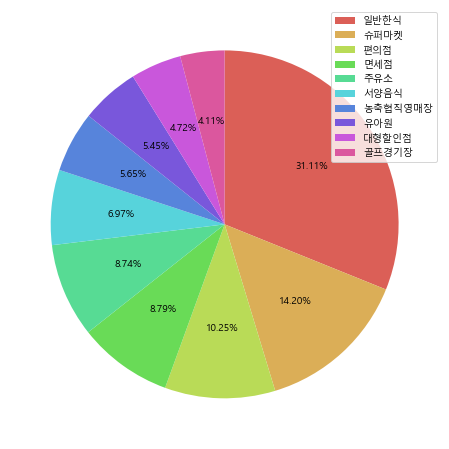

In [61]:
value = data.groupby('Type').sum()
value.reset_index(inplace=True)
value = value[['Type', 'TotalSpent']]

#value['Spent_Ratio']=(value['TotalSpent']/168687712199)
#value
sorted_value = value.sort_values(by='TotalSpent' ,ascending=False)
Value_TOP10=sorted_value.head(10)

labels = Value_TOP10['Type']
frequency = Value_TOP10['TotalSpent']
colors = sns.color_palette('hls', len(labels))

fig = plt.figure(figsize = (8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()

pie = ax.pie(frequency,
             startangle=90,
             counterclock=False,
             autopct = lambda p:'{:.2f}%'.format(p), ## 퍼센티지 출력
       colors = colors ## 색상 지정
       )
plt.legend(pie[0],labels) ## 범례 표시
plt.show()

## 2.2 업종 별 재난지원금 사용금액 상위 10개 업종 PieChart 시각화

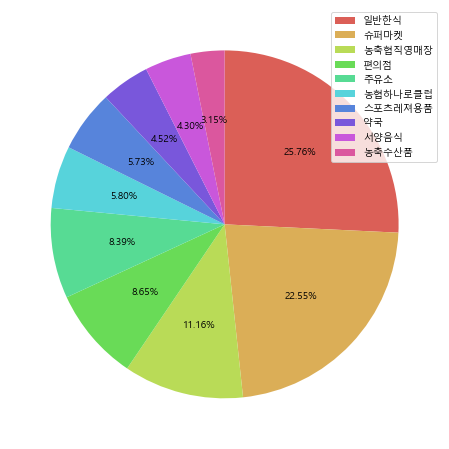

In [63]:
Dis_value = data.groupby('Type').sum()
Dis_value.reset_index(inplace=True)
Dis_value = Dis_value[['Type', 'DisSpent']]


#value['Spent_Ratio']=(value['TotalSpent']/168687712199)
#value
Dis_sorted_value = Dis_value.sort_values(by='DisSpent' ,ascending=False)
Dis_Value_TOP10=Dis_sorted_value.head(10)

labels = Dis_Value_TOP10['Type']
frequency = Dis_Value_TOP10['DisSpent']
colors = sns.color_palette('hls', len(labels))

fig = plt.figure(figsize = (8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()

pie = ax.pie(frequency,
             startangle=90,
             counterclock=False,
             autopct = lambda p:'{:.2f}%'.format(p), ## 퍼센티지 출력
       colors = colors ## 색상 지정
       )
plt.legend(pie[0],labels) ## 범례 표시
plt.show()

## 2.3 업종 별 소비 시간 대 분석

In [71]:
data['Count'] = 1
spent_time = data.groupby(['YM', 'Type', 'Time']).sum()
spent_time.reset_index(inplace=True)
spent_time = spent_time[['YM','Type','Time','TotalSpent','DisSpent','NumofSpent','NumofDisSpent','Count']]

spent_time

,YM,Type,Time,TotalSpent,DisSpent,NumofSpent,NumofDisSpent,Count
0,202005,1급호텔,0,95000,0,2,0,1
1,202005,1급호텔,1,122000,0,2,0,1
2,202005,1급호텔,3,164000,0,5,0,3
3,202005,1급호텔,4,183500,0,4,0,3
4,202005,1급호텔,5,60000,0,1,0,1
...,...,...,...,...,...,...,...,...
14027,202008,화장품,20,23242220,7100,803,1,104
14028,202008,화장품,21,17957380,28700,440,2,84
14029,202008,화장품,22,8865000,47000,113,1,54
14030,202008,화장품,23,5087900,0,57,0,34


분석 기간 중 전체 소비 금액은 점진적 증가가 있었으며, 재난 지원금 사용금액과 비교하여 보았을 때, 재난 지원금 투입 이후 소비 활성화 효과가 있었 던 것으로 보임

In [127]:
path = 'C:\\Windows\\Fonts\\굴림 보통.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=9).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(30,30))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Windows\\Fonts\\굴림 보통.ttf'

In [96]:
t_data = data.groupby(['YM', 'Time', 'Type']).sum()
t_data.reset_index(inplace=True)
t_data= t_data[['YM','Time', 'Type', 'Count','TotalSpent','DisSpent','NumofSpent','NumofDisSpent']]

t_data

,YM,Time,Type,Count,TotalSpent,DisSpent,NumofSpent,NumofDisSpent
0,202005,0,1급호텔,1,95000,0,2,0
1,202005,0,2급호텔,4,327000,0,4,0
2,202005,0,LPG,11,1153161,155030,42,7
3,202005,0,가방,1,70000,0,1,0
4,202005,0,골프경기장,50,15680208,0,276,0
...,...,...,...,...,...,...,...,...
14027,202008,24,홍삼제품,6,1746250,0,10,0
14028,202008,24,화랑,1,68000,0,2,0
14029,202008,24,화물운송,2,131000,0,2,0
14030,202008,24,화원,29,1408999,0,45,0


<function matplotlib.pyplot.show(close=None, block=None)>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


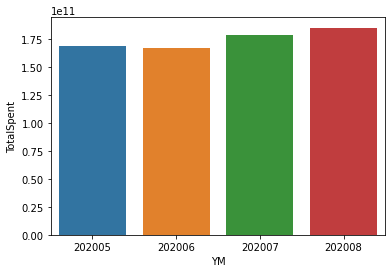

In [73]:
total_spent = data.groupby('YM').sum()
total_spent.reset_index(inplace=True)
total_spent = total_spent[['YM', 'TotalSpent', 'DisSpent']]

sns.barplot(
    data = total_spent,
    x = 'YM',
    y = 'TotalSpent'
)

plt.show

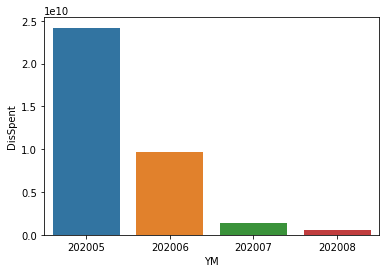

In [75]:
total_spent = data.groupby('YM').sum()
total_spent.reset_index(inplace=True)
total_spent = total_spent[['YM', 'TotalSpent','DisSpent']]

sns.barplot(
    data = total_spent,
    x = 'YM',
    y = 'DisSpent'
)
plt.show()

In [128]:
def types_spent_visual(type_name: str)->str:
    temp = data[data['Type'] == type_name]
    temp = temp.groupby('YM').sum()
    temp.reset_index(inplace=True)
    temp = temp[['YM', 'TotalSpent', 'DisSpent']]

    fig = plt.figure(figsize=(20,10))
    plt.title(type_name)
    
    ax1 = fig.add_subplot(2, 3, 1)
    ax1 = sns.barplot(
        data = temp,
        x = 'YM',
        y = 'TotalSpent'
    ) 
    
    ax2 = fig.add_subplot(2, 3, 2)
    ax2 = sns.barplot(
        data = temp,
        x='YM',
        y='DisSpent'
    )
    
    ax3 = fig.add_subplot(2, 3, 3)
    sns.barplot(
    data = temp,
    x='YM',
    y='DisSpent'
    )

    tdata = t_data[t_data['Type']==type_name]

    ax4 = fig.add_subplot(2, 3, 4)
    ax4 = sns.lineplot(data = tdata, x='Time', y='TotalSpent', hue='YM')
    
    ax5 = fig.add_subplot(2, 3, 5)
    ax5 = sns.lineplot(data = tdata, x='Time', y='DisSpent',hue='YM')

    ax6 = fig.add_subplot(2, 3, 6)
    ax6 = sns.lineplot(data = tdata, x='Time', y='Count', hue='YM')

    
    plt.show()

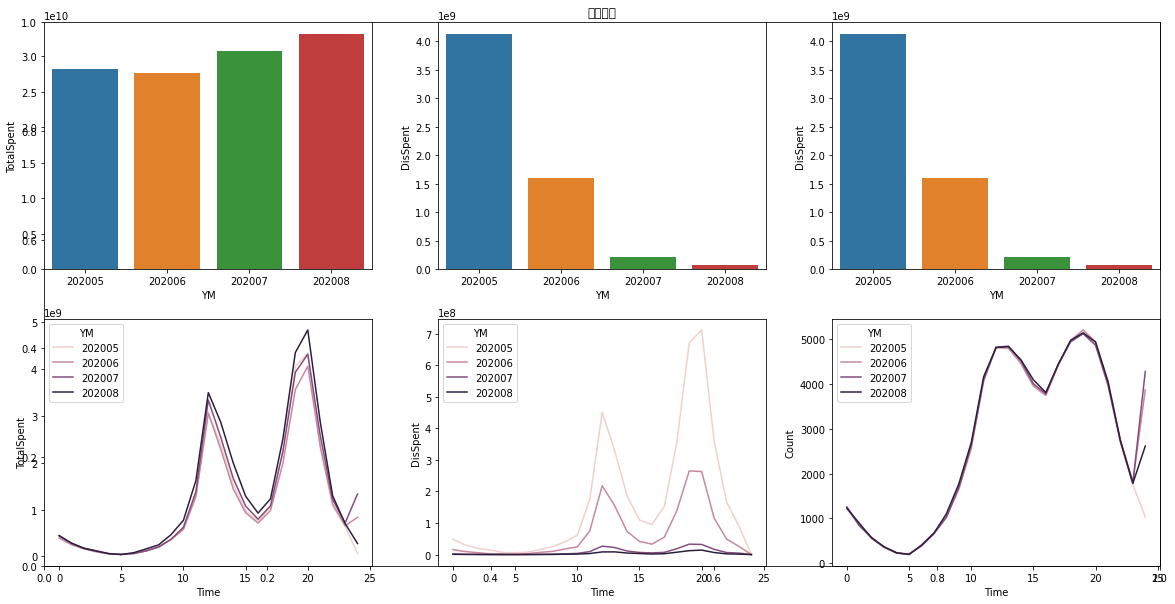

In [129]:
types_spent_visual('일반한식')

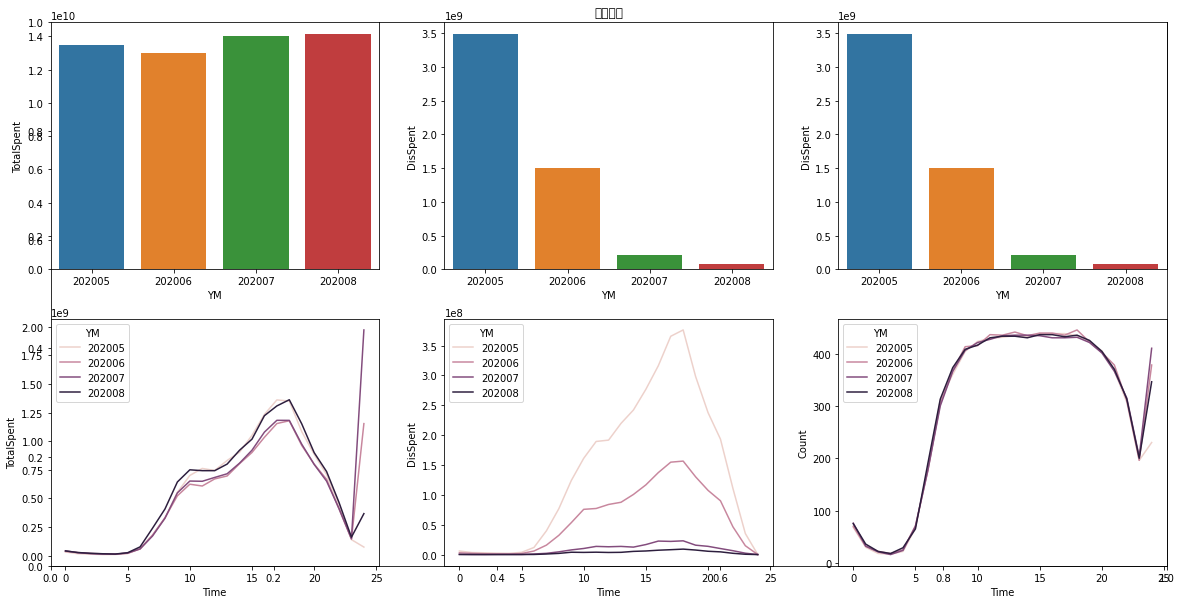

In [130]:
types_spent_visual('슈퍼마켓')

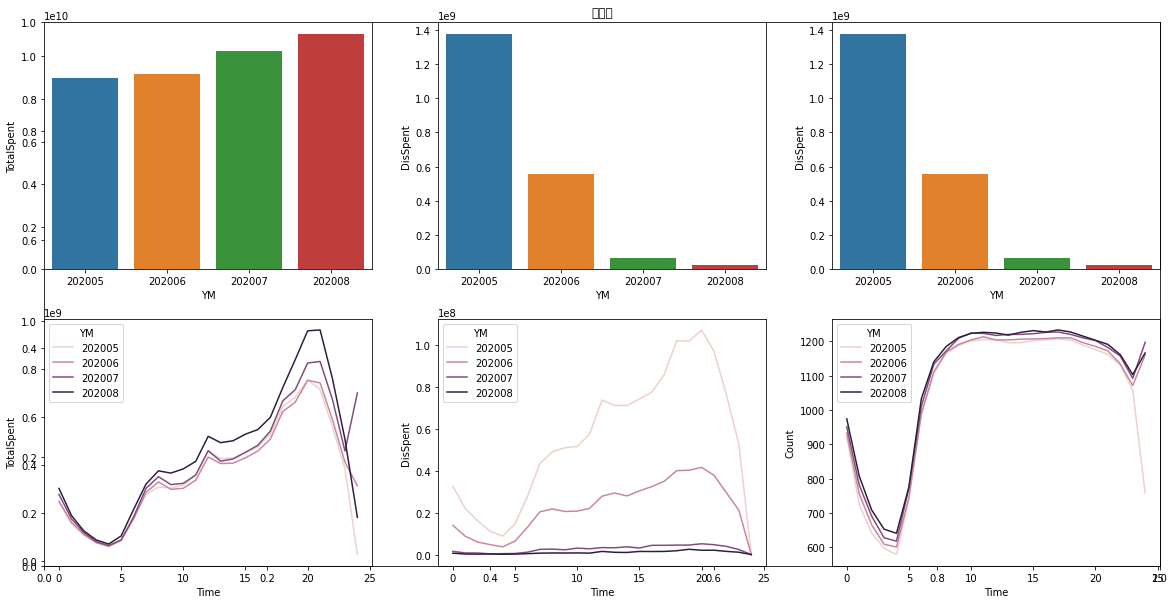

In [131]:
types_spent_visual('편의점')

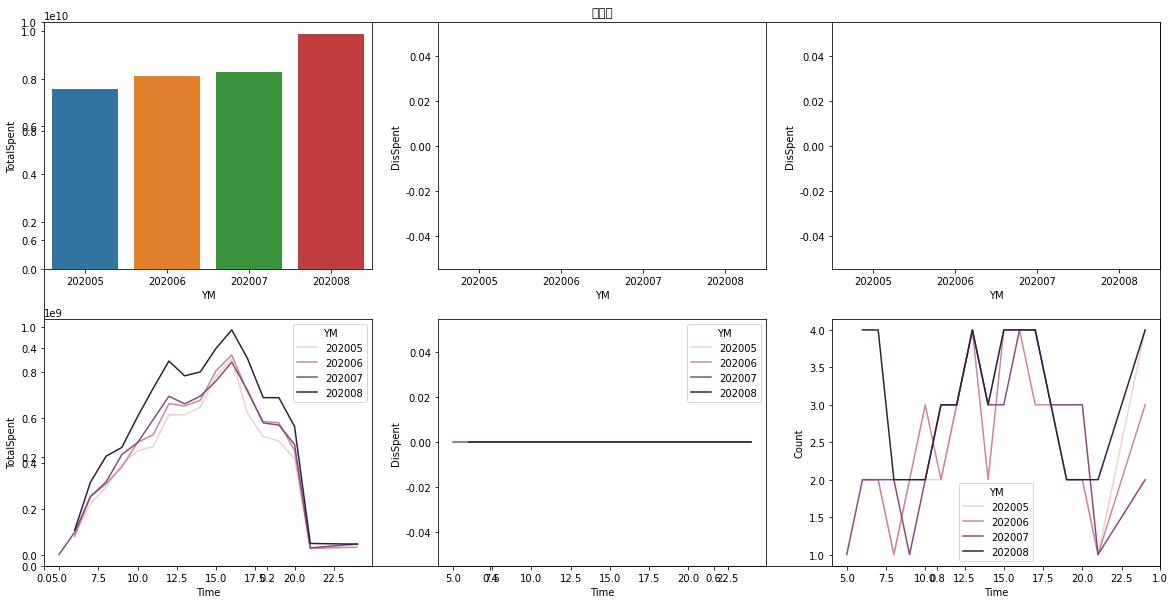

In [132]:
types_spent_visual('면세점')

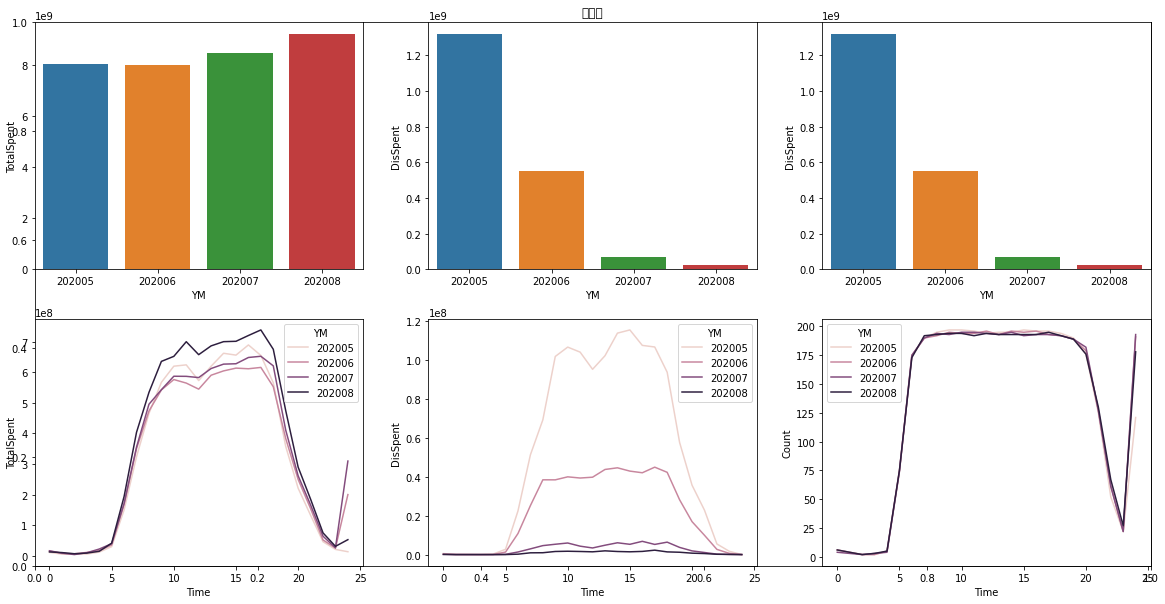

In [133]:
types_spent_visual('주유소')

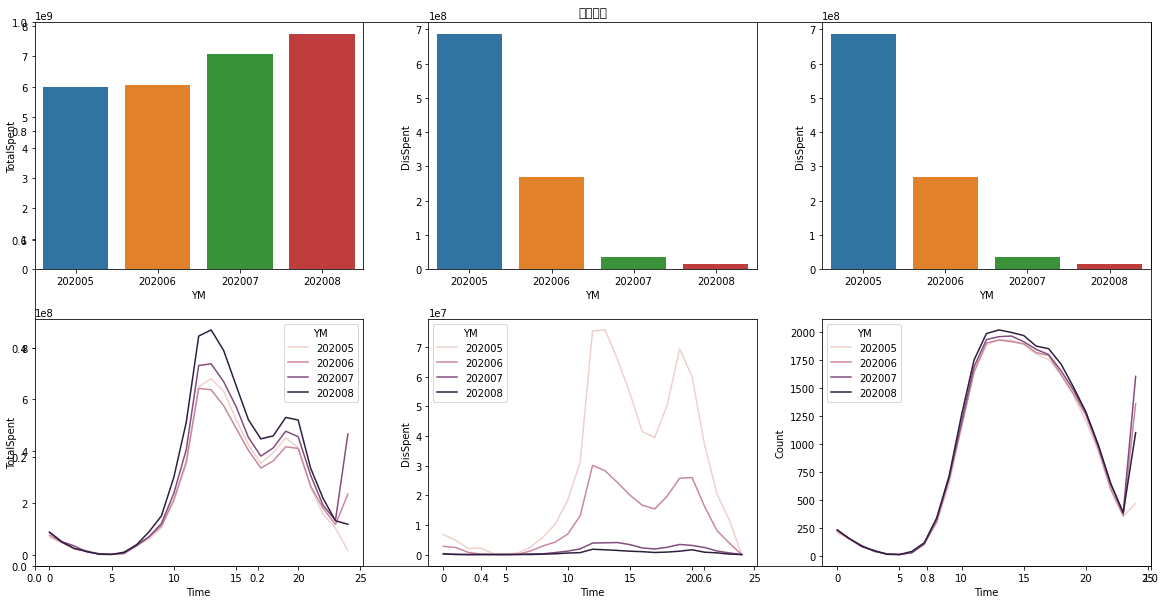

In [134]:
types_spent_visual('서양음식')

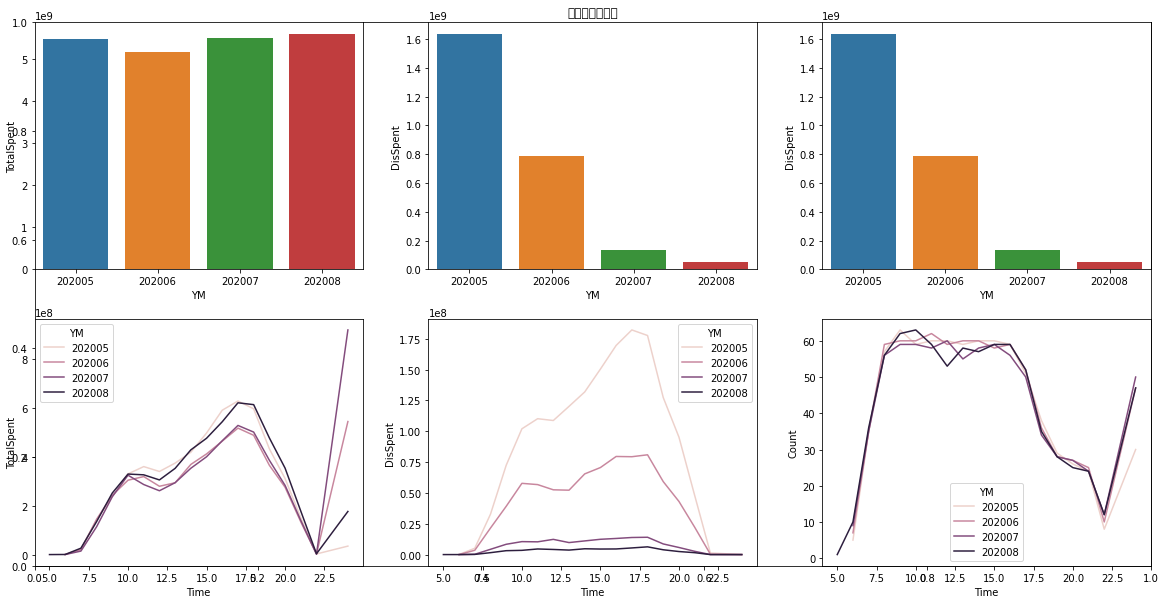

In [135]:
types_spent_visual('농축협직영매장')

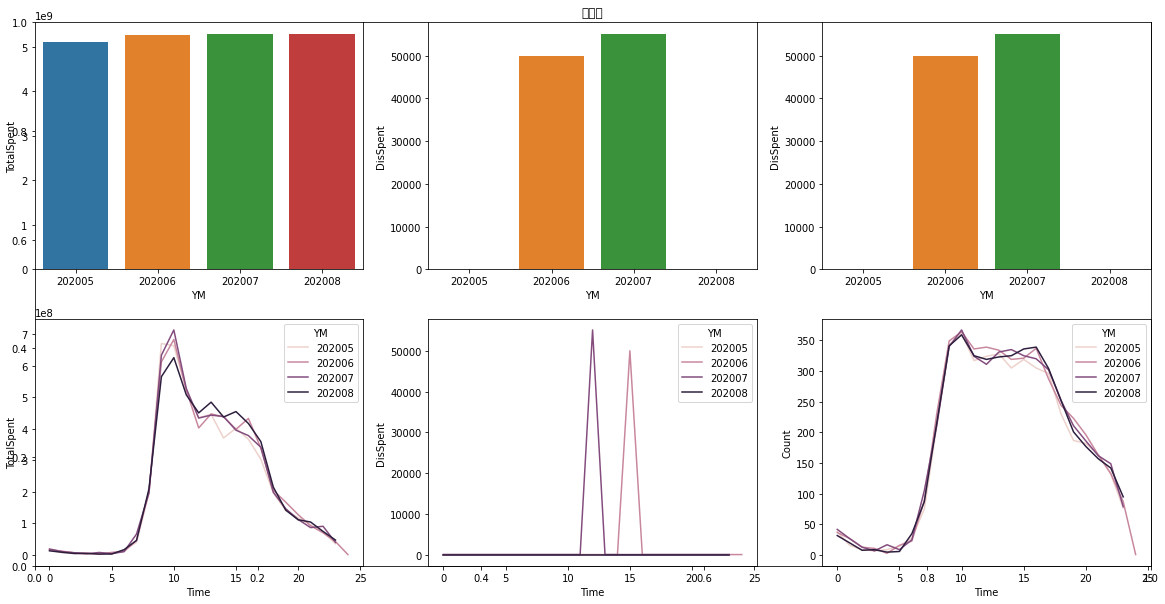

In [136]:
types_spent_visual('유아원')

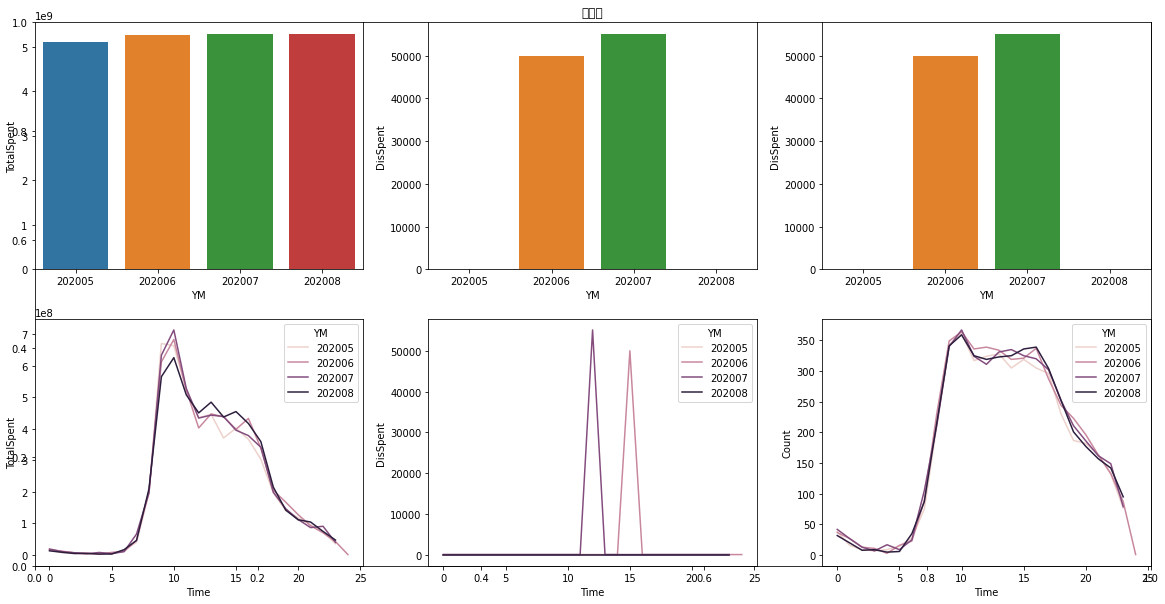

In [137]:
types_spent_visual('유아원')

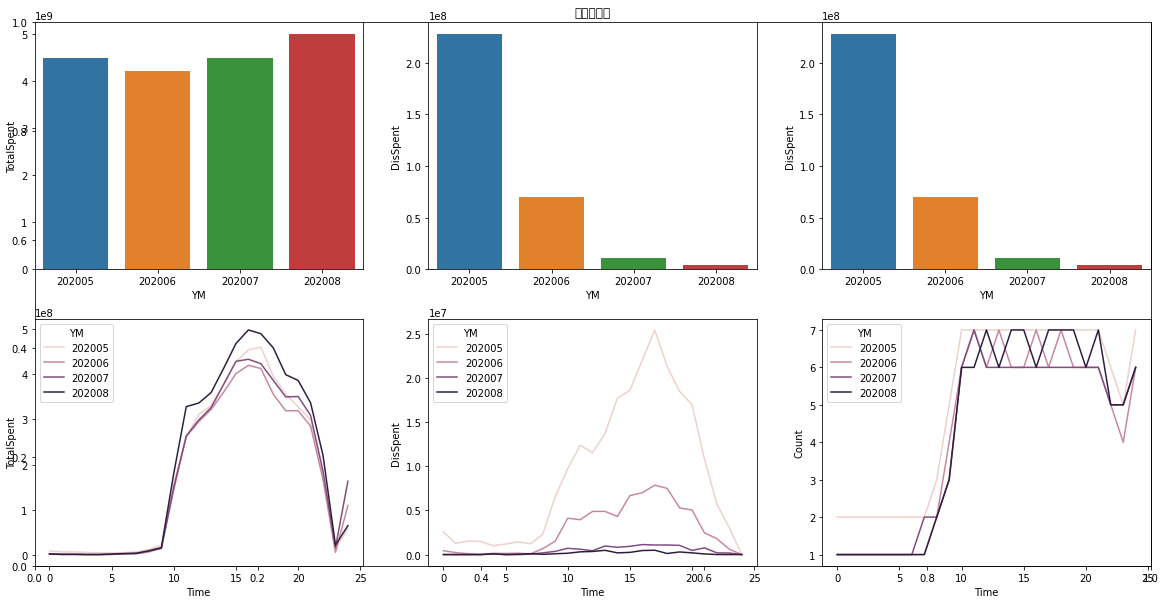

In [139]:
types_spent_visual('대형할인점')

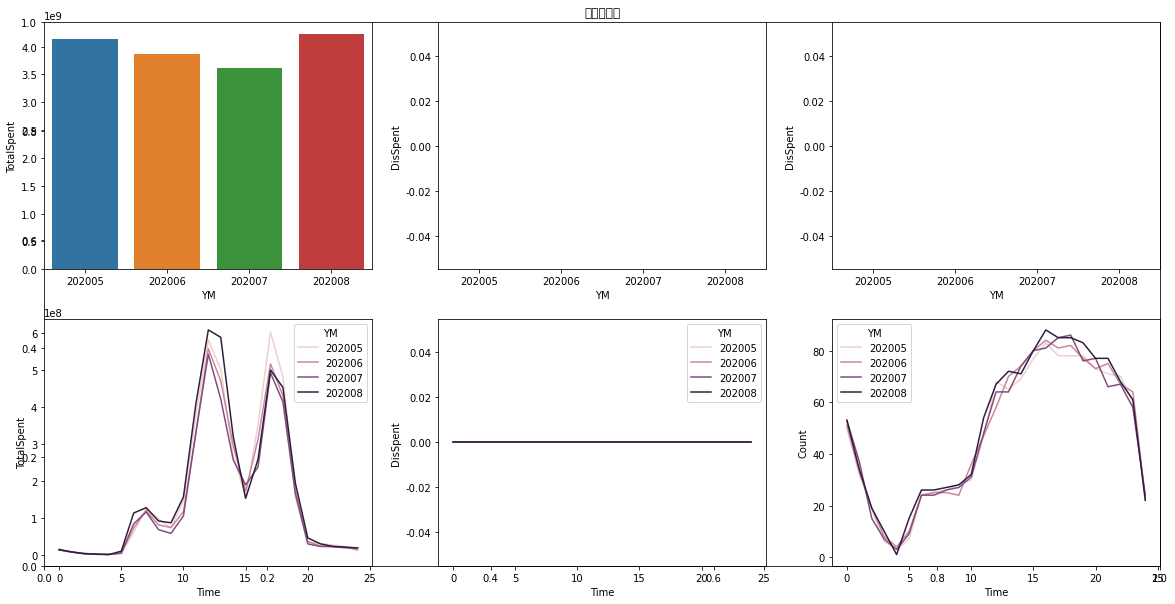

In [140]:
types_spent_visual('골프경기장')